In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn import preprocessing
from sklearn import model_selection

# Linear regression
from sklearn import linear_model

# Kernel regression
from sklearn import kernel_ridge
from sklearn import svm

# Tree based regression
from sklearn import tree
from sklearn import ensemble

# Neural Network regression
from sklearn import neural_network

# Print versions
print pd.__version__
import sklearn
print sklearn.__version__

0.19.2
0.18.1


# Utilities

In [3]:
def error(predicted, actual):
    """Error is the RMS of the ln(price)
    difference between predicted and actual.
    """
    Nval = len(actual)
    ln_actual = np.log(actual)
    ln_predicted = np.log(predicted)
    diff = ln_predicted - ln_actual
    return np.sqrt(np.sum(diff**2)/Nval)


def predict_sale_price(df, scaler, reg):
    """Create a DataFrame that adds the predicted sale price and residual.
    
    Note: scaler has to be determined from the training set only outside of here.
    """
    df_copy = df.copy()
    
    # Extract just the features
    df_copy_feat = df_copy.drop('Id', axis=1)
    if 'SalePrice' in df_copy.columns:
        df_copy_feat = df_copy_feat.drop('SalePrice', axis=1)
    
    # Predict 'SalePrice'
    X = df_copy_feat.values
    X = scaler.fit_transform(X)
    y_pred = reg.predict(X)
    saleprice_pred = np.exp(y_pred)
    df_copy['SalePricePred'] = saleprice_pred
    
    # Calculate residual if 'SalePrice' is available
    if 'SalePrice' in df_copy.columns:
        df_copy['SalePriceRes'] = df_copy['SalePricePred'] - df_copy['SalePrice']
    
    return df_copy

In [4]:
def cross_validation_error(reg, X_train, y_train, cv=10):
    """Calculate the cross-validation error.
    
    The function cross_val_score feeds N(k-1)/k examples into reg.fit(X, y) at a time, 
    then calculates the score with the other N/k examples.
    The larger k (cv) is, the more data you train on, so the cv goes down with k.
    Leave-one-out is optimal.
    """
    # list of negative MSE
    nmse = model_selection.cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

    # What you actually want is the *ROOT*-mean-squared error
    cv_errors = np.sqrt(-nmse)

    # Return the average CV error
    return np.mean(cv_errors)

In [5]:
def powers_to_label(features, powers):
    """Get label for the specified term in the polynomial.
    
    Parameters
    ----------
    features : list of strings
        Names of each feature in the term
    powers : list of integers
        The exponent for each feature
    
    Returns
    -------
    label : str
    
    Convert list of powers and list of column labels to string.
    Ex: powers_to_label([1, 0, 3], ['x', 'y', 'z']) returns 'x_z^3'
    """
    nfeat = len(powers)
    label = ''
    for i in range(nfeat):
        feature = features[i]
        power = powers[i]
        # Don't label c^0
        if power>0:
            # Don't write exponent for x^1
            if power==1:
                label += feature+'*'
            else:
                label += feature+'^'+str(power)+'*'
    # Remove last '*'
    return label[:-1]


def add_polynomial_features(df, columns, **kwargs):
    """Add polynomial features created from a list of columns to a DataFrame.
    
    Parameters
    ----------
    df : pandas DataFrame
    columns : list of columns
    **kwargs : passed to PolynomialFeatures
    
    Returns
    -------
    df_poly : pandas DataFrame
        Same as df, but with the polynomial features added.
    """
    # Subset of the data with just the specified columns 
    df_sub = df[columns]
    poly = preprocessing.PolynomialFeatures(**kwargs)
    data = poly.fit_transform(df_sub)
    
    # Create names of the new polynomial features
    features = list(df_sub.columns)
    labels = []
    # For each term in polynomial get the exponent for each feature
    for powers in poly.powers_:
        label = powers_to_label(features, powers)
        labels.append(label)
    
    # Copy the data frame and add the new features
    # Overwrite the columns that already exist for the linear terms
    df_poly = df.copy()
    ncol = len(labels)
    for i in range(ncol):
        label = labels[i]
        col_data = data[:, i]
        df_poly[label] = col_data
        
    return df_poly

In [6]:
def plot_coefficients(columns, reg):
    """Plot the coefficients as a horizontal bar plot
    ranked by magnitude of coefficient.
    """
    ncoef = len(columns)
    
    # Labels for bars
    y_label = list(columns)
    # Position of bars
    y_pos = np.arange(ncoef)
    # Lengths of bars
    x_pos = list(reg.coef_)
    #print len(y_label), len(y_pos), len(x_pos)
    
    coef_sorted = [[y_label[i], x_pos[i]] for i in range(ncoef)]
    coef_sorted = sorted(coef_sorted, key=lambda x: np.abs(x[1]))
    
    y_label = [coef_sorted[i][0] for i in range(ncoef)]
    x_pos = [coef_sorted[i][1] for i in range(ncoef)]
    
    # Split plot into 2 columns
    nsplit = ncoef//2
    
    ncol1 = len(y_pos[nsplit:])
    y_pos1 = np.arange(ncol1)
    ncol2 = len(y_pos[:nsplit])
    y_pos2 = np.arange(ncol2)
    
    x_posmax = max(x_pos)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 15)) 
    
    ax1.barh(y_pos1, x_pos[nsplit:], align='center', alpha=0.5)
    ax1.set_yticks(y_pos1)
    ax1.set_yticklabels(y_label[nsplit:])
    ax1.set_xlabel('Weight')
    ax1.set_ylabel('Feature')
    ax1.set_ylim(y_pos1[0]-1, y_pos1[-1]+1)
    ax1.set_xlim(-x_posmax, x_posmax)
    ax1.grid()
    
    ax2.barh(y_pos2, x_pos[:nsplit], align='center', alpha=0.5)
    ax2.set_yticks(y_pos2)
    ax2.set_yticklabels(y_label[:nsplit])
    ax2.set_xlabel('Weight')
    ax2.set_ylabel('Feature')
    ax2.set_ylim(y_pos2[0]-1, y_pos2[-1]+1)
    ax2.set_xlim(-x_posmax, x_posmax)
    ax2.grid()
    fig.tight_layout()
    return fig, ax1, ax2

# Read cleaned data

In [7]:
# Data with X AND y.
# You will later split this into training and validation sets.
df_labeled = pd.read_csv('train_clean.csv')

# Data with just X. You submit your prediction for y.
df_test = pd.read_csv('test_clean.csv')

print df_labeled.shape, df_test.shape
print df_labeled.columns

(1460, 53) (1459, 52)
Index([u'Id', u'SalePrice', u'OverallQual', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'TotalBsmtSF', u'1stFlrSF', u'FullBath',
       u'TotRmsAbvGrd', u'YearBuilt', u'MasVnrArea', u'Fireplaces',
       u'BsmtFinSF1', u'LotFrontage', u'ExterQual', u'BsmtQual',
       u'KitchenQual', u'BsmtFinType1', u'HeatingQC', u'GarageFinish',
       u'GarageType', u'Foundation_BrkTil', u'Foundation_CBlock',
       u'Foundation_PConc', u'Foundation_Slab', u'Foundation_Stone',
       u'Foundation_Wood', u'Neighborhood_Blmngtn', u'Neighborhood_Blueste',
       u'Neighborhood_BrDale', u'Neighborhood_BrkSide',
       u'Neighborhood_ClearCr', u'Neighborhood_CollgCr',
       u'Neighborhood_Crawfor', u'Neighborhood_Edwards',
       u'Neighborhood_Gilbert', u'Neighborhood_IDOTRR',
       u'Neighborhood_MeadowV', u'Neighborhood_Mitchel', u'Neighborhood_NAmes',
       u'Neighborhood_NPkVill', u'Neighborhood_NWAmes',
       u'Neighborhood_NoRidge', u'Neighborhood_NridgHt',
      

# Split data into training/validation/test sets

Here, validation set is also called a hold-out set. You could use it for hyperparameter optimization. You can also break up the training set into k pieces and do k-fold cross validation. After hyperparameter optimization, the errors of the two should be about the same, but the validation/hold-out set will likely have a higher variance. Still, use the validation set as a test that you are not screwing up anything with k-fold CV.

In [8]:
def train_validation_split(df, **kwargs):
    """Split a DataFrame into training-set and validation-set DataFrames.
    """
    # Keep 'Id' as a feature.
    df_features = df.drop(['SalePrice'], axis=1)
    X = df_features.values
    y = df['SalePrice'].values
    
    # Do split
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, **kwargs)
    
    # Training set DataFrame
    df_train = pd.DataFrame(data=X_train, columns=df_features.columns)
    df_train.insert(1, 'SalePrice', y_train)
    
    # Validation set DataFrame
    df_val = pd.DataFrame(data=X_val, columns=df_features.columns)
    df_val.insert(1, 'SalePrice', y_val)
    
    return df_train, df_val

In [9]:
# Do the train/validation split. 
# Standard practice seems to be 70%/30% split for training/validation sets.
# A 90%/10% split is suggested here:
# http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/

df_train, df_val = train_validation_split(df_labeled, train_size=0.7, random_state=0)

In [10]:
print df_train.shape, df_val.shape, df_test.shape

(1021, 53) (439, 53) (1459, 52)


# Set up for linear regression

1. Add polynomial features. 
2. Feature scaling.

In [110]:
# Create polynomial features
col_poly = [ 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 
        '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 
        'ExterQual', 'BsmtQual', 'KitchenQual', 'BsmtFinType1', 'HeatingQC', 'GarageFinish']

df_train_poly = add_polynomial_features(df_train, col_poly, 
                                   degree=2, interaction_only=False, include_bias=False)
df_val_poly = add_polynomial_features(df_val, col_poly, 
                                   degree=2, interaction_only=False, include_bias=False)
df_test_poly = add_polynomial_features(df_test, col_poly, 
                                  degree=2, interaction_only=False, include_bias=False)

# Convert data to numpy arrays
# Predict ln(y) instead of y
y_train = np.log(df_train_poly['SalePrice'].values)
y_val = np.log(df_val_poly['SalePrice'].values)

X_train = df_train_poly.drop(['Id', 'SalePrice'], axis=1).values
X_val = df_val_poly.drop(['Id', 'SalePrice'], axis=1).values
X_test = df_test_poly.drop('Id', axis=1).values

# Create feature scaling object (mean/standard-deviation scaling).
# Only use the training set for determining the scaling. 
# Otherwise, you indirectly use information about the validation set.
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Perform feature scaling
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Names of features
feat_columns = df_train_poly.columns.drop(['Id', 'SalePrice'])

In [111]:
print y_train.shape, y_val.shape
print X_train.shape, X_val.shape, X_test.shape
print len(feat_columns)

(1021,) (439,)
(1021, 171) (439, 171) (1459, 171)
171


## Linear regression

Nonzero coefficients: 171
intecept = 12.0220972637
(cv, train, val) = 0.152594237502, 0.115901770457, 0.167959562105)


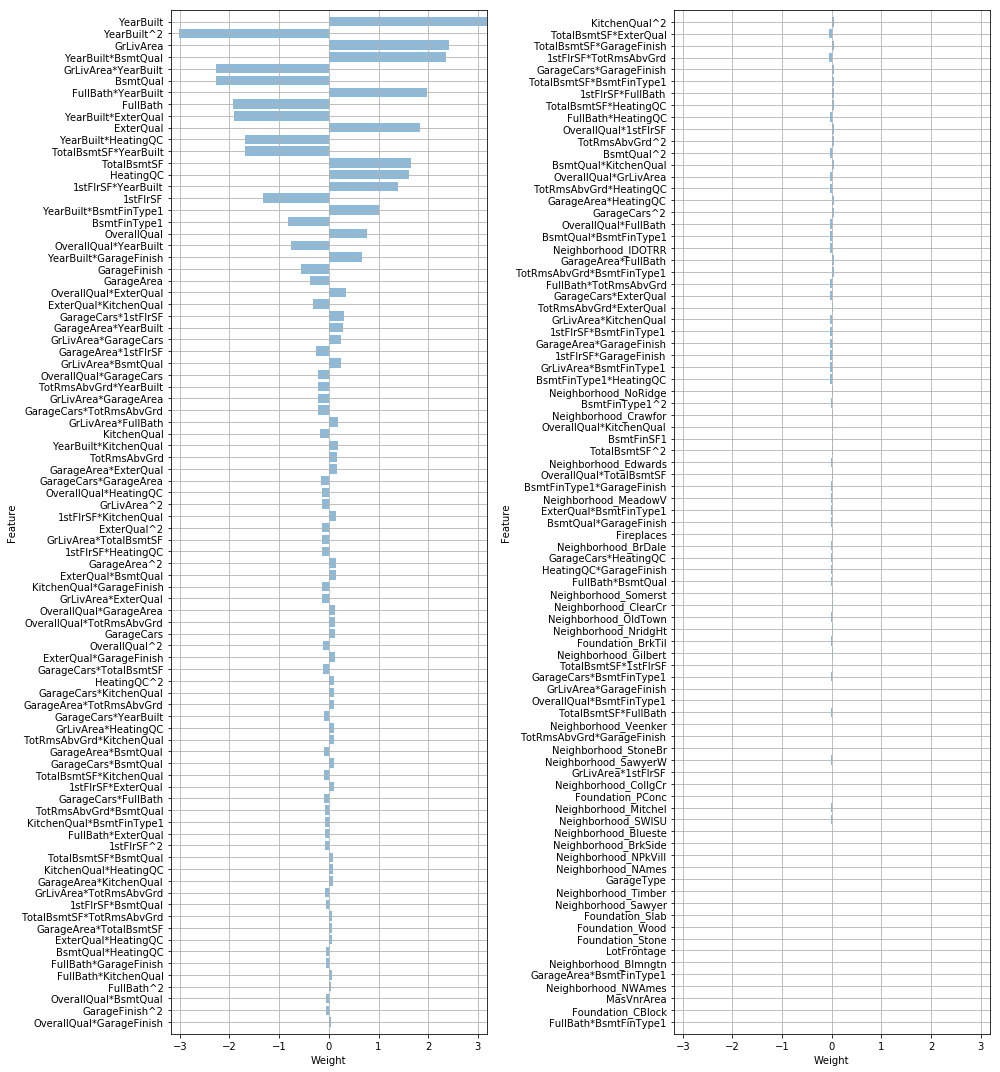

In [112]:
# Linear regression without regularization

reg = linear_model.LinearRegression()

err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))

print 'Nonzero coefficients: '+str(len(reg.coef_[np.abs(reg.coef_)>0]))
print 'intecept = {}'.format(reg.intercept_)
print '(cv, train, val) = {}, {}, {})'.format(err_cv, err_train, err_val) 
fig, ax1, ax2 = plot_coefficients(feat_columns, reg)

alpha = 12.3284673944
Nonzero coefficients: 171
intecept = 12.0220972637
(cv, train, val) = 0.139837625402, 0.124431128448, 0.142332464321)


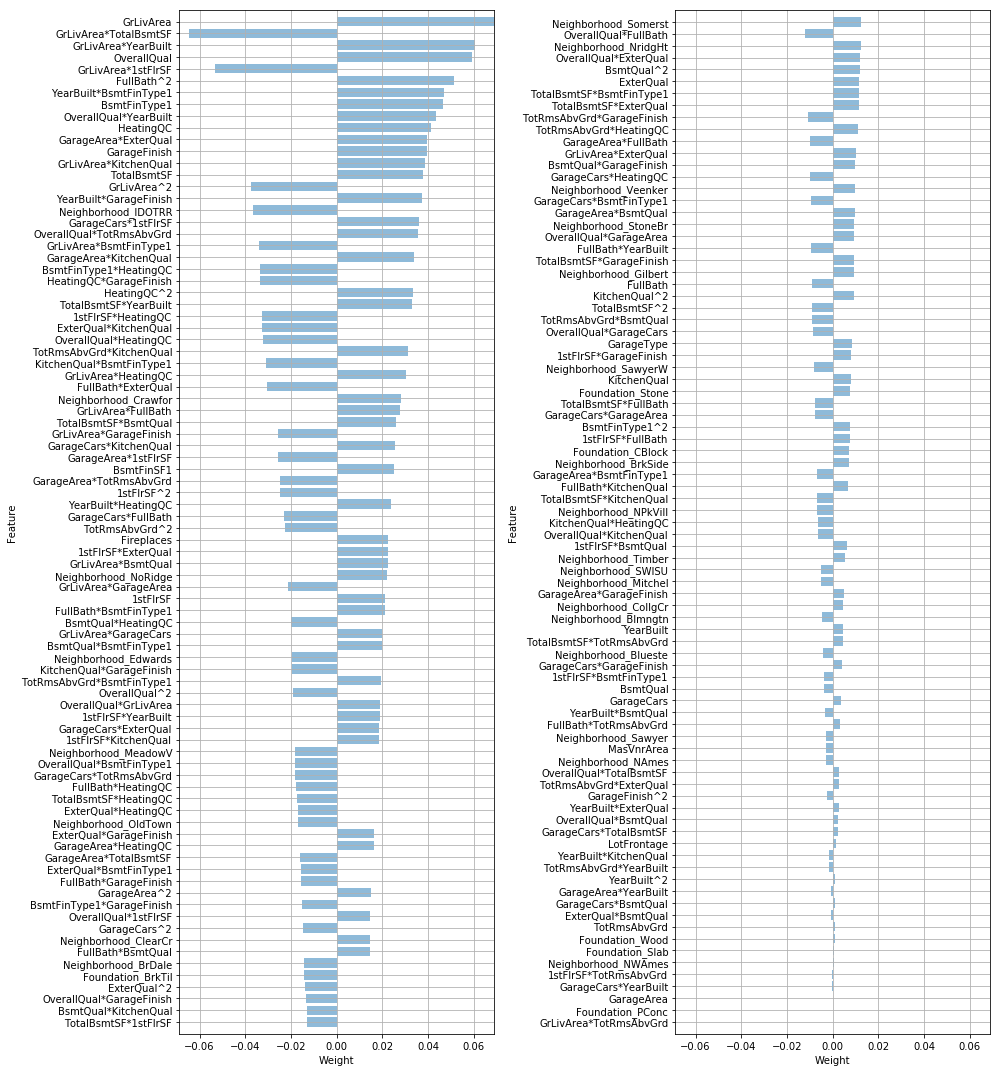

In [113]:
# The L_2 regularization parameter

alphas = np.logspace(-4, 4, 100)
reg = linear_model.RidgeCV(alphas=alphas, cv=10)

err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))

print 'alpha = {}'.format(reg.alpha_)
print 'Nonzero coefficients: '+str(len(reg.coef_[np.abs(reg.coef_)>0]))
print 'intecept = {}'.format(reg.intercept_)
print '(cv, train, val) = {}, {}, {})'.format(err_cv, err_train, err_val) 
fig, ax1, ax2 = plot_coefficients(feat_columns, reg)

alpha = 0.000253536449397
Nonzero coefficients: 104
intecept = 12.0220972637
(cv, train, val) = 0.142052836206, 0.122910595202, 0.144518553877)


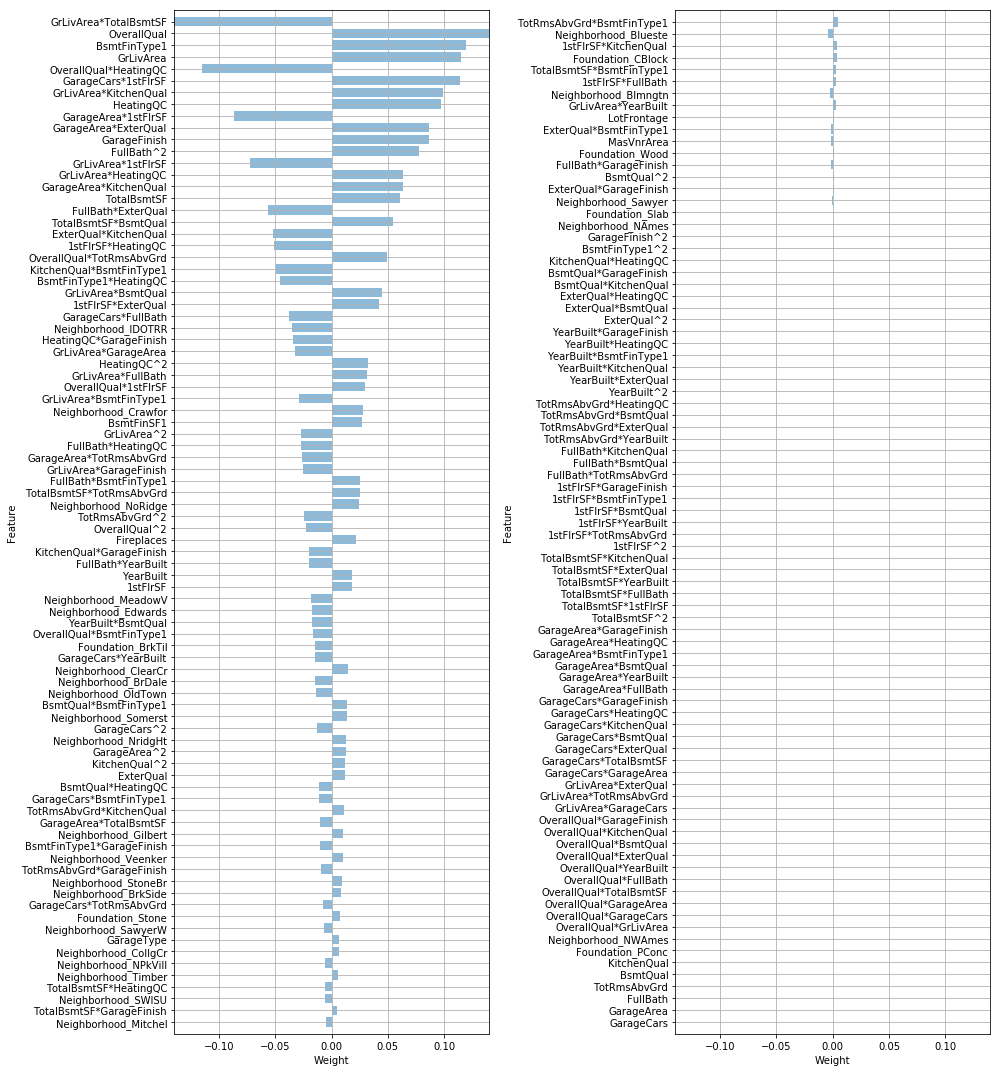

In [114]:
# The L_1 regularization parameter

alphas = np.logspace(-4, 4, 100)
reg = linear_model.LassoCV(alphas=alphas, cv=10)

err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))

print 'alpha = {}'.format(reg.alpha_)
print 'Nonzero coefficients: '+str(len(reg.coef_[np.abs(reg.coef_)>0]))
print 'intecept = {}'.format(reg.intercept_)
print '(cv, train, val) = {}, {}, {})'.format(err_cv, err_train, err_val) 
fig, ax1, ax2 = plot_coefficients(feat_columns, reg)

alpha = 0.00599484250319
l1_ratio = 0.00215443469003
Nonzero coefficients: 170
intecept = 12.0220972637
(cv, train, val) = 0.140882014359, 0.122823066914, 0.14268030395)


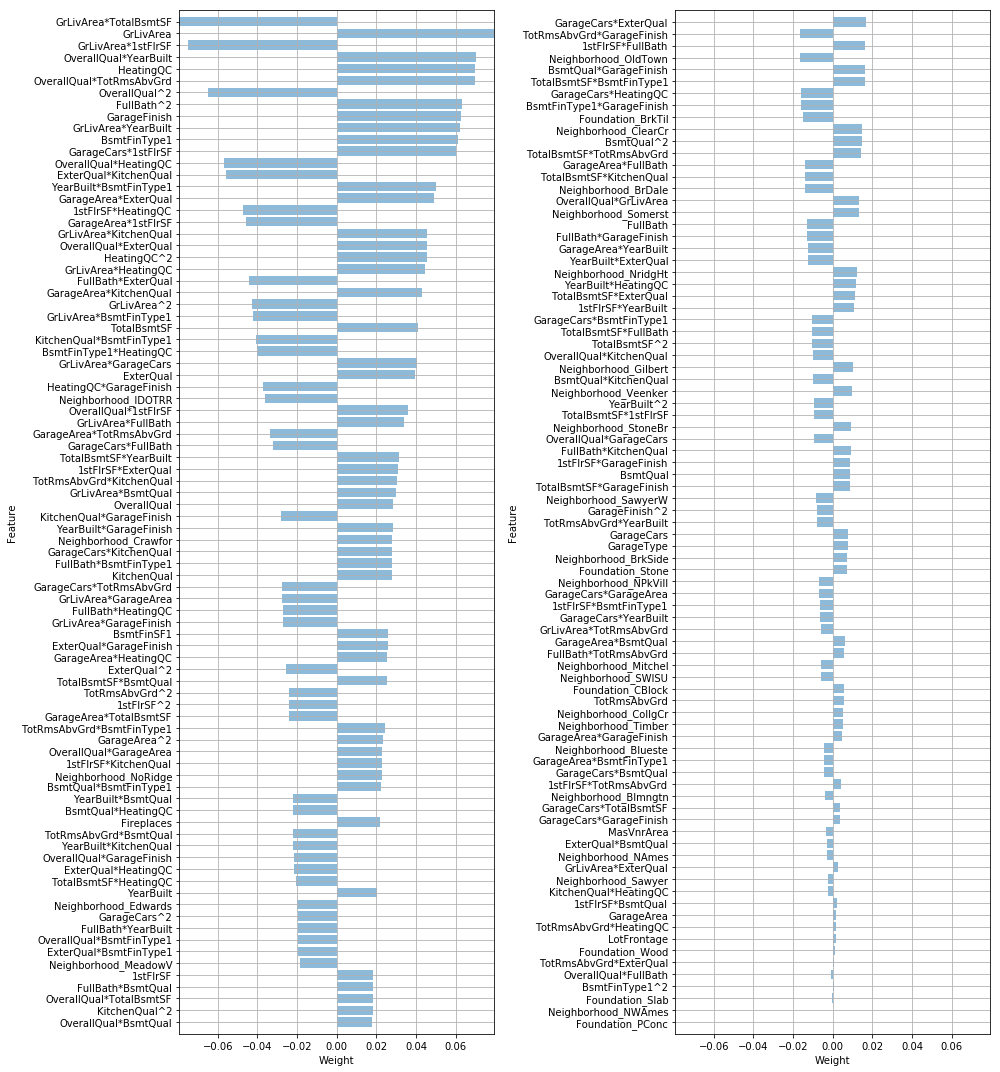

In [115]:
# ElasticNet has both L_1 and L_2 regularization terms with separate parameters

# l1_ratio is the fraction of L_1 regularization. It lies in the range [0, 1].
l1_ratio = np.logspace(-4, 0, 10)
alphas = np.logspace(-4, 4, 10)
reg = linear_model.ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=10)

err_cv = cross_validation_error(reg, X_train, y_train, cv=2)

reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))

print 'alpha = {}'.format(reg.alpha_)
print 'l1_ratio = {}'.format(reg.l1_ratio_)
print 'Nonzero coefficients: '+str(len(reg.coef_[np.abs(reg.coef_)>0]))
print 'intecept = {}'.format(reg.intercept_)
print '(cv, train, val) = {}, {}, {})'.format(err_cv, err_train, err_val) 
fig, ax1, ax2 = plot_coefficients(feat_columns, reg)

# Set up for all other forms of regression

1. (No polynomial features needed.)
2. Feature scaling.

In [1]:
# Convert data to numpy arrays
# Predict ln(y) instead of y
y_train = np.log(df_train['SalePrice'].values)
y_val = np.log(df_val['SalePrice'].values)

X_train = df_train.drop(['Id', 'SalePrice'], axis=1).values
X_val = df_val.drop(['Id', 'SalePrice'], axis=1).values
X_test = df_test.drop('Id', axis=1).values

# Create feature scaling object (mean/standard-deviation scaling).
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Perform feature scaling
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Names of features
feat_columns = df_train.columns.drop(['Id', 'SalePrice'])

NameError: name 'np' is not defined

In [12]:
print y_train.shape, y_val.shape
print X_train.shape, X_val.shape, X_test.shape
print len(feat_columns)

(1021,) (439,)
(1021, 51) (439, 51) (1459, 51)
51


# KernelRidge regression

Linear regression with RBF kernel and L_2 regularization

In [118]:
print '[alpha, gamma, cv, train, val]'
err_array = []
for alpha in np.logspace(-4, 4, 10):
    for gamma in np.logspace(-3, 1, 10):
        reg = kernel_ridge.KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
        
        err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_val = reg.predict(X_val)
        err_train = error(np.exp(y_pred_train), np.exp(y_train))
        err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
        err = [alpha, gamma, err_cv, err_train, err_val]
        print err
        err_array.append(err)

err_array = np.array(err_array)

[alpha, gamma, cv, train, val]
[0.0001, 0.001, 0.22979332027940372, 0.065749144170307652, 0.23954865966145888]
[0.0001, 0.0027825594022071257, 0.30449464732469161, 0.036081354668065002, 0.447577099810193]
[0.0001, 0.0077426368268112694, 0.40251843779287511, 0.012262763619673565, 1.0520161520654496]
[0.0001, 0.021544346900318832, 0.96438622159654641, 0.0049267445440348704, 1.7319648080657934]
[0.0001, 0.059948425031894091, 2.7288691935292624, 0.0036802030458218649, 3.024124898875284]
[0.0001, 0.1668100537200059, 6.3366224387763861, 0.003297641100852173, 6.1855657044184138]
[0.0001, 0.46415888336127775, 9.9541984407755333, 0.0031415121843994843, 9.868432964431177]
[0.0001, 1.2915496650148828, 11.434707009591706, 0.0029980782334340854, 11.523348786466027]
[0.0001, 3.5938136638046259, 11.803457703643566, 0.0029367785717564466, 11.907209454938823]
[0.0001, 10.0, 11.900189538133652, 0.0029253623452615007, 11.999589291421959]
[0.00077426368268112698, 0.001, 0.20682194223630149, 0.086068977804

In [119]:
#print np.sort(err_array[:, 2])
imin = np.argmin(err_array[:, 2])
err_array[imin]

array([ 0.00599484,  0.001     ,  0.20345726,  0.10912385,  0.21606876])

## Support vector regression

RBF and polynomial kernels

SVR is like kernel regression, but with an unusual loss function. 
No loss when the model is within a ball $|\vec x|<\epsilon$ of the sample $|\vec x_i|$.

In [ ]:
reg = svm.SVR(C=C, kernel='rbf', gamma=gamma)
        
        err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_val = reg.predict(X_val)
        err_train = error(np.exp(y_pred_train), np.exp(y_train))
        err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
        err = [C, gamma, err_cv, err_train, err_val]
        print err
        err_array.append(err)

In [234]:
estimator = svm.SVR()

# Search over these parameters
Cs = np.logspace(-2, 4, 20)
gammas = np.logspace(-4, -1, 20)
parameters = {'kernel':['rbf'], 'C':Cs, 'gamma':gammas}

# Set up the grid
# n_jobs=-1 runs jobs in parallel on all available cores
grid = model_selection.GridSearchCV(estimator, parameters, scoring='neg_mean_squared_error', cv=10, 
                                    n_jobs=-1, verbose=1)

# Fit to data for each of the hyperparameter combinations.
# This passes the .fit() method to model_selection.cross_val_score() which then passes it to svm.SVR()
grid.fit(X_train, y_train)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  5.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'C': array([  1.00000e-02,   2.06914e-02,   4.28133e-02,   8.85867e-02,
         1.83298e-01,   3.79269e-01,   7.84760e-01,   1.62378e+00,
         3.35982e+00,   6.95193e+00,   1.43845e+01,   2.97635e+01,
         6.15848e+01,   1.27427e+02,   2.63665e+02,   5.45559e+...546,
        0.00785,  0.01129,  0.01624,  0.02336,  0.0336 ,  0.04833,
        0.06952,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [235]:
grid.param_grid

{'C': array([  1.00000000e-02,   2.06913808e-02,   4.28133240e-02,
          8.85866790e-02,   1.83298071e-01,   3.79269019e-01,
          7.84759970e-01,   1.62377674e+00,   3.35981829e+00,
          6.95192796e+00,   1.43844989e+01,   2.97635144e+01,
          6.15848211e+01,   1.27427499e+02,   2.63665090e+02,
          5.45559478e+02,   1.12883789e+03,   2.33572147e+03,
          4.83293024e+03,   1.00000000e+04]),
 'gamma': array([ 0.0001    ,  0.00014384,  0.00020691,  0.00029764,  0.00042813,
         0.00061585,  0.00088587,  0.00127427,  0.00183298,  0.00263665,
         0.00379269,  0.00545559,  0.0078476 ,  0.01128838,  0.01623777,
         0.02335721,  0.03359818,  0.0483293 ,  0.06951928,  0.1       ]),
 'kernel': ['rbf']}

In [236]:
grid.best_params_

{'C': 263.66508987303553, 'gamma': 0.00042813323987193956, 'kernel': 'rbf'}

In [237]:
# Best estimator
# When refit=True (by default), best_estimator_ is refit on all the data (not just the train split).
reg = grid.best_estimator_

err_cv = np.sqrt(-grid.best_score_)

y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))

[err_cv, err_train, err_val]

[0.13339072600961763, 0.11032913010478028, 0.10433975327833328]

In [238]:
cv_err = np.sqrt(-grid.cv_results_['mean_test_score'])
params = grid.cv_results_['params']
err_array = np.array([[params[i]['C'], params[i]['gamma'], cv_err[i]] for i in range(len(cv_err))])

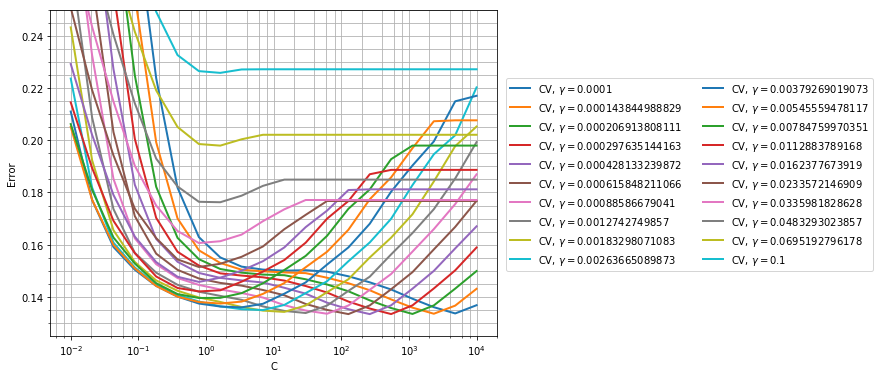

In [241]:
err_re = err_array.reshape((20, 20, 3))

fig, ax = plt.subplots(figsize=(8, 6))
ngamma = len(err_re[0])
for i in range(ngamma):
    gamma = err_re[0, i, 1]
    ax.plot(err_re[:, i, 0], err_re[:, i, 2], lw=2, label=r'CV, $\gamma=$'+str(gamma))

# # Reset color cycle
# ax.set_prop_cycle(None)
# for i in range(ngamma):
#     gamma = err_re[0, i, 1]
#     ax.plot(err_re[:, i, 0], err_re[:, i, 4], lw=2, ls='--', label=r'Val, $\gamma=$'+str(gamma))
      
ax.set_xscale('log')
ax.set_ylim(0.125, 0.25)
ax.set_xlabel(r'C')
ax.set_ylabel('Error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend(ncol=2, loc=(1.02, 0.2))

In [136]:
print '[C, gamma, cv, train, val]'
err_array = []
for C in np.logspace(-4, 4, 10):
    for gamma in np.logspace(-4, 1, 10):
        reg = svm.SVR(C=C, kernel='rbf', gamma=gamma)
        
        err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_val = reg.predict(X_val)
        err_train = error(np.exp(y_pred_train), np.exp(y_train))
        err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
        err = [C, gamma, err_cv, err_train, err_val]
        print err
        err_array.append(err)

err_array = np.array(err_array)

# Optimize hyperparameters based on cross validation error
imin = np.argmin(err_array[:, 2])
err_array[imin]

[C, gamma, cv, train, val]
[0.0001, 0.0001, 0.40090715295354495, 0.4026286500467679, 0.3938831618178969]
[0.0001, 0.00035938136638046257, 0.40063268969779875, 0.4023240676099612, 0.39357362585290001]
[0.0001, 0.001291549665014884, 0.39976688681115313, 0.40138034512276799, 0.39260778733966195]
[0.0001, 0.0046415888336127824, 0.39801854233652662, 0.39945444710147254, 0.39060764916868002]
[0.0001, 0.016681005372000592, 0.39761125655344792, 0.39908034648553403, 0.39012570065449104]
[0.0001, 0.059948425031894091, 0.40008777678835844, 0.4017287679906214, 0.39293309123692077]
[0.0001, 0.21544346900318845, 0.40089336356128891, 0.40255164709677288, 0.39386775968418292]
[0.0001, 0.77426368268112777, 0.40099441336487696, 0.40265563457884618, 0.39398341775004325]
[0.0001, 2.7825594022071258, 0.4010021045374807, 0.40266439626881079, 0.39399230931754692]
[0.0001, 10.0, 0.40100343803795913, 0.40266559866814355, 0.39399329912779885]
[0.00077426368268112698, 0.0001, 0.40014027174518285, 0.4018041278610

array([  1.66810054e+02,   3.59381366e-04,   1.35999846e-01,
         1.16524839e-01,   1.36301778e-01])

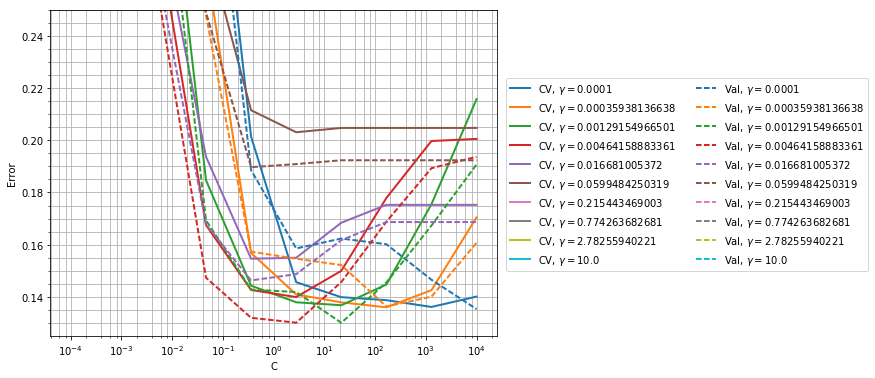

In [139]:
err_re = err_array.reshape((10, 10, 5))

fig, ax = plt.subplots(figsize=(8, 6))
ngamma = len(err_re[0])
for i in range(ngamma):
    gamma = err_re[0, i, 1]
    ax.plot(err_re[:, i, 0], err_re[:, i, 2], lw=2, label=r'CV, $\gamma=$'+str(gamma))

# Reset color cycle
ax.set_prop_cycle(None)
for i in range(ngamma):
    gamma = err_re[0, i, 1]
    ax.plot(err_re[:, i, 0], err_re[:, i, 4], lw=2, ls='--', label=r'Val, $\gamma=$'+str(gamma))
      
ax.set_xscale('log')
ax.set_ylim(0.125, 0.25)
ax.set_xlabel(r'C')
ax.set_ylabel('Error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend(ncol=2, loc=(1.02, 0.2))

In [140]:
print '[C, degree, cv, train, val]'
err_array = []
for C in np.logspace(-3, 2, 10):
    for degree in [2, 3]:
        reg = svm.SVR(C=C, kernel='poly', degree=degree)
        
        err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_val = reg.predict(X_val)
        err_train = error(np.exp(y_pred_train), np.exp(y_train))
        err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
        err = [C, degree, err_cv, err_train, err_val]
        print err
        err_array.append(err)

err_array = np.array(err_array)

# Optimize hyperparameters based on cross validation error
imin = np.argmin(err_array[:, 2])
err_array[imin]

[C, degree, cv, train, val]
[0.001, 2, 0.39190932576415383, 0.39115549730220844, 0.38296995513196619]
[0.001, 3, 0.36963973407861561, 0.36517490888821097, 0.36225707999311563]
[0.0035938136638046258, 2, 0.37027923028382037, 0.36460659587943184, 0.35741903902351729]
[0.0035938136638046258, 3, 0.30696358174465771, 0.29488292171997399, 0.33198578759501324]
[0.01291549665014884, 2, 0.31898981712360952, 0.30435463833347309, 0.30782641738563932]
[0.01291549665014884, 3, 0.23939821763497085, 0.22224607216222095, 0.31268755846217927]
[0.046415888336127795, 2, 0.26810644083023771, 0.2432329941492816, 0.28212004357219628]
[0.046415888336127795, 3, 0.19110617498195409, 0.16137758504551453, 0.21877751153737363]
[0.1668100537200059, 2, 0.23785206205024023, 0.19191785298119637, 0.28161400032695932]
[0.1668100537200059, 3, 0.16826113284537536, 0.12177659072445991, 0.18104652897762286]
[0.59948425031894093, 2, 0.23089556264515201, 0.15207875967097406, 0.26241727202537279]
[0.59948425031894093, 3, 0.16

array([ 0.59948425,  3.        ,  0.16824777,  0.09861575,  0.1893447 ])

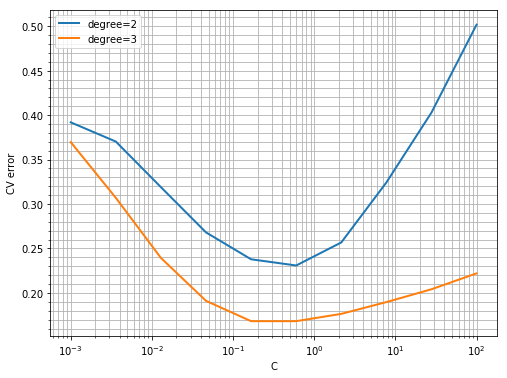

In [141]:
err_re = err_array.reshape((10, 2, 5))

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(err_re[:, 0, 0], err_re[:, 0, 2], lw=2, label='degree=2')
ax.plot(err_re[:, 1, 0], err_re[:, 1, 2], lw=2, label='degree=3')

ax.set_xscale('log')
ax.set_xlabel(r'C')
ax.set_ylabel('CV error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

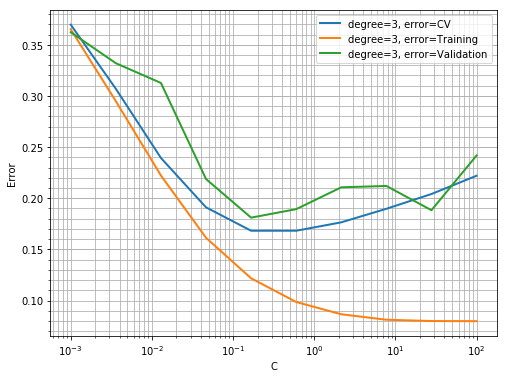

In [142]:
err_re = err_array.reshape((10, 2, 5))

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(err_re[:, 1, 0], err_re[:, 1, 2], lw=2, label='degree=3, error=CV')
ax.plot(err_re[:, 1, 0], err_re[:, 1, 3], lw=2, label='degree=3, error=Training')
ax.plot(err_re[:, 1, 0], err_re[:, 1, 4], lw=2, label='degree=3, error=Validation')

ax.set_xscale('log')
ax.set_xlabel(r'C')
ax.set_ylabel('Error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

## Decision tree regressor

Hyperparameter discussion:
https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre

The main difference between the two is that min_samples_leaf guarantees a minimum number of samples in a leaf, while min_samples_split can create arbitrary small leaves, though min_samples_split is more common in the literature.

In [72]:
# Maximum number of binary branches from trunk to leaf
max_depth = 5
# Minimum number of samples required to split an internal node
min_samples_split = 2
# Minimum number of samples in each leaf (final subdivision)
#min_samples_leaf = 2
#reg = tree.DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
reg = tree.DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)

err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
err = [max_depth, err_cv, err_train, err_val]
err

[5, 0.20979401627801023, 0.16423517149845218, 0.1901559844949931]

In [92]:
len(range(5, 70, 5))

13

In [93]:
print '[max_depth, min_samples_split, cv, train, val]'
err_array = []
for max_depth in range(5, 70, 5):
    print max_depth
    for min_split in range(2, 100, 1):
        reg = tree.DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_split)
        
        err_cv = cross_validation_error(reg, X_train, y_train, cv=10)
        
        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_val = reg.predict(X_val)
        err_train = error(np.exp(y_pred_train), np.exp(y_train))
        err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
        err = [max_depth, min_split, err_cv, err_train, err_val]
        #print err
        err_array.append(err)

err_array = np.array(err_array)

# Optimize hyperparameters based on cross validation error
imin = np.argmin(err_array[:, 2])
err_array[imin]

[max_depth, min_samples_split, cv, train, val]
5
10
15
20
25
30
35
40
45
50
55
60
65


array([ 45.        ,  35.        ,   0.20127933,   0.14458541,   0.17912793])

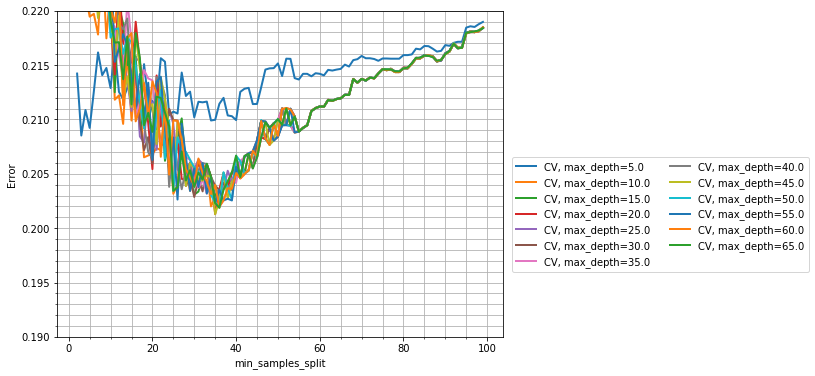

In [97]:
err_re = err_array.reshape((13, 98, 5))

fig, ax = plt.subplots(figsize=(8, 6))
max_depth = len(err_re)
for i in range(max_depth):
    max_depth = err_re[i, 0, 0]
    ax.plot(err_re[i, :, 1], err_re[i, :, 2], lw=2, label=r'CV, max_depth='+str(max_depth))
      
ax.set_ylim(0.19, 0.22)
ax.set_xlabel(r'min_samples_split')
ax.set_ylabel('Error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend(ncol=2, loc=(1.02, 0.2))

In [90]:
len(range(2, 100, 2))

49

# Random Forest Regression

In [98]:
max_depth = 20
min_samples_split = 35

print '[n_est, cv, train, val]'
err_array = []
for n_est in [10, 30, 100, 300, 1000]:
    reg = ensemble.RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, min_samples_split=min_samples_split)

    err_cv = cross_validation_error(reg, X_train, y_train, cv=2)

    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)
    err_train = error(np.exp(y_pred_train), np.exp(y_train))
    err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
    err = [n_est, err_cv, err_train, err_val]
    print err
    err_array.append(err)

err_array = np.array(err_array)

# Optimize hyperparameters based on cross validation error
imin = np.argmin(err_array[:, 2])
err_array[imin]

[n_est, cv, train, val]
[10, 0.16857446877667687, 0.13819159765964475, 0.14850988559547387]
[30, 0.16617282784167392, 0.13292100315657596, 0.14817951409921695]
[100, 0.16436538194691092, 0.13020758788092593, 0.14492701669497379]
[300, 0.16392122459960573, 0.1294208125498347, 0.14505855399202566]
[1000, 0.163887900792927, 0.13000372455430817, 0.14558163466162236]


array([  3.00000000e+02,   1.63921225e-01,   1.29420813e-01,
         1.45058554e-01])

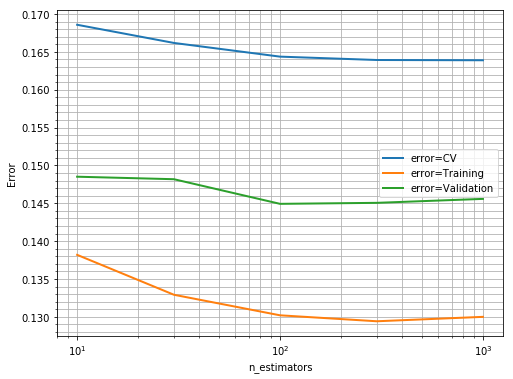

In [99]:
#err_re = err_array.reshape((10, 2, 5))

err_re = err_array

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(err_re[:, 0], err_re[:, 1], lw=2, label='error=CV')
ax.plot(err_re[:, 0], err_re[:, 2], lw=2, label='error=Training')
ax.plot(err_re[:, 0], err_re[:, 3], lw=2, label='error=Validation')

ax.set_xscale('log')
ax.set_xlabel(r'n_estimators')
ax.set_ylabel('Error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

## Multilayer perceptron regressor


For regression, the last node doesn't have an activation function (i.e. identity activation),
and the output layer only has 1 node because it's predicting 1 value.
The number of nodes per layer will be
(nfeatures, hls0, hls1, hls2, ..., 1).




Advise for choosing number and hidden layers and nodes per hidden layer:

https://stackoverflow.com/questions/10565868/multi-layer-perceptron-mlp-architecture-criteria-for-choosing-number-of-hidde

1. Start with 1 hidden layer.

2. Start with number nodes = number of input nodes (features), then trim. Choose the number that the minimizes validation error.

3. Add another layer.



In [13]:
estimator = neural_network.MLPRegressor()

# Search over these parameters
hls = [(l1, l2) for l1 in [10, 20, 30, 40, 50] for l2 in [10, 20, 30]]
print hls
alphas = np.logspace(-3, 3, 10)
parameters = {'hidden_layer_sizes':hls, 'alpha':alphas}

# Set up the grid
# n_jobs=-1 runs jobs in parallel on all available cores
grid = model_selection.GridSearchCV(estimator, parameters, scoring='neg_mean_squared_error', cv=10, 
                                    n_jobs=-1, verbose=1)

# Fit to data for each of the hyperparameter combinations.
# This passes the .fit() method to model_selection.cross_val_score() which then passes it to the estimator object
grid.fit(X_train, y_train)

[(10, 10), (10, 20), (10, 30), (20, 10), (20, 20), (20, 30), (30, 10), (30, 20), (30, 30), (40, 10), (40, 20), (40, 30), (50, 10), (50, 20), (50, 30)]
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarni

GridSearchCV(cv=10, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([  1.00000e-03,   4.64159e-03,   2.15443e-02,   1.00000e-01,
         4.64159e-01,   2.15443e+00,   1.00000e+01,   4.64159e+01,
         2.15443e+02,   1.00000e+03]), 'hidden_layer_sizes': [(10, 10), (10, 20), (10, 30), (20, 10), (20, 20), (20, 30), (30, 10), (30, 20), (30, 30), (40, 10), (40, 20), (40, 30), (50, 10), (50, 20), (50, 30)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_

In [15]:
# Best estimator
# When refit=True (by default), best_estimator_ is refit on all the data (not just the train split).
print grid.best_params_
reg = grid.best_estimator_

err_cv = np.sqrt(-grid.best_score_)

y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
err_val = error(np.exp(y_pred_val), np.exp(y_val))

[err_cv, err_train, err_val]

{'alpha': 215.44346900318823, 'hidden_layer_sizes': (50, 30)}


[0.27737353548169091, 0.38907988299049734, 0.39814303585775557]

In [30]:
len(grid.cv_results_['params']), range(len(cv_err))

(150,
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149])

In [33]:
i=0
[[params[i]['alpha'], params[i]['hidden_layer_sizes'], cv_err[i]] for i in range(150)]

[[0.001, (10, 10), 1.2103067291781888],
 [0.001, (10, 20), 1.0479833529792733],
 [0.001, (10, 30), 1.0096415680246169],
 [0.001, (20, 10), 0.95145969271973496],
 [0.001, (20, 20), 0.85297445642048308],
 [0.001, (20, 30), 0.84024715350900248],
 [0.001, (30, 10), 0.91195050451739257],
 [0.001, (30, 20), 0.77076711139411147],
 [0.001, (30, 30), 0.74691369478718639],
 [0.001, (40, 10), 0.8559282225062349],
 [0.001, (40, 20), 0.72077556651459151],
 [0.001, (40, 30), 0.65330151153170946],
 [0.001, (50, 10), 0.7145318601442715],
 [0.001, (50, 20), 0.6516826729182208],
 [0.001, (50, 30), 0.70133986019057848],
 [0.0046415888336127772, (10, 10), 1.1091777616767218],
 [0.0046415888336127772, (10, 20), 1.0220273031667524],
 [0.0046415888336127772, (10, 30), 0.99207259480652421],
 [0.0046415888336127772, (20, 10), 1.0773057201057894],
 [0.0046415888336127772, (20, 20), 0.98557778324973733],
 [0.0046415888336127772, (20, 30), 0.81649831169735887],
 [0.0046415888336127772, (30, 10), 0.872308360816544

In [23]:
cv_err = np.sqrt(-grid.cv_results_['mean_test_score'])
params = grid.cv_results_['params']
err_array = np.array([[params[i]['alpha'], params[i]['hidden_layer_sizes'], cv_err[i]] for i in range(len(cv_err))])

ValueError: setting an array element with a sequence.

In [ ]:
err_re = err_array.reshape((20, 20, 3))

fig, ax = plt.subplots(figsize=(8, 6))
ngamma = len(err_re[0])
for i in range(ngamma):
    gamma = err_re[0, i, 1]
    ax.plot(err_re[:, i, 0], err_re[:, i, 2], lw=2, label=r'CV, $\gamma=$'+str(gamma))

# # Reset color cycle
# ax.set_prop_cycle(None)
# for i in range(ngamma):
#     gamma = err_re[0, i, 1]
#     ax.plot(err_re[:, i, 0], err_re[:, i, 4], lw=2, ls='--', label=r'Val, $\gamma=$'+str(gamma))
      
ax.set_xscale('log')
ax.set_ylim(0.125, 0.25)
ax.set_xlabel(r'C')
ax.set_ylabel('Error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend(ncol=2, loc=(1.02, 0.2))

In [147]:
err_array = []
for hl1 in [10, 20, 30, 40, 45, 51]:
    for alpha in np.logspace(-1, 2, 15):
        hls = (hl1, 20)
        #hls = (hl1,)
        reg = neural_network.MLPRegressor(solver='lbfgs', alpha=alpha, hidden_layer_sizes=hls, random_state=0)
        
        err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_val = reg.predict(X_val)
        err_train = error(np.exp(y_pred_train), np.exp(y_train))
        err_val = error(np.exp(y_pred_val), np.exp(y_val))
        
        err = [hl1, alpha, err_cv, err_train, err_val]
        print err
        err_array.append(err)

err_array = np.array(err_array)

# Optimize hyperparameters based on cross validation error
imin = np.argmin(err_array[:, 2])
err_array[imin]

[10, 0.10000000000000001, 0.20277501186226549, 0.11190639051306936, 0.2231308112889982]
[10, 0.16378937069540642, 0.19524833878389938, 0.11312173509065376, 0.22100336798671991]
[10, 0.26826957952797259, 0.18388678173772802, 0.11031166274779025, 0.2181372289067216]
[10, 0.43939705607607904, 0.18244939843321559, 0.11068627267359628, 0.19938232299864889]
[10, 0.71968567300115194, 0.1527348392841687, 0.11011311870897293, 0.17689812890891068]
[10, 1.1787686347935873, 0.15111409508583615, 0.11280474912619798, 0.16560688646688937]
[10, 1.9306977288832496, 0.15031883219616993, 0.11433337939247437, 0.15174901171102767]
[10, 3.1622776601683795, 0.14214087519863958, 0.11810294040164586, 0.15933822804094838]
[10, 5.1794746792312099, 0.14090771361957311, 0.11190577098925841, 0.14390974198484313]
[10, 8.4834289824407172, 0.1406869842294371, 0.1296588103699528, 0.15877421218026569]
[10, 13.894954943731374, 0.14263576783851079, 0.13686492688391619, 0.15819950687991804]
[10, 22.758459260747887, 0.14433

array([ 40.        ,   5.17947468,   0.13640874,   0.11561991,   0.14132656])

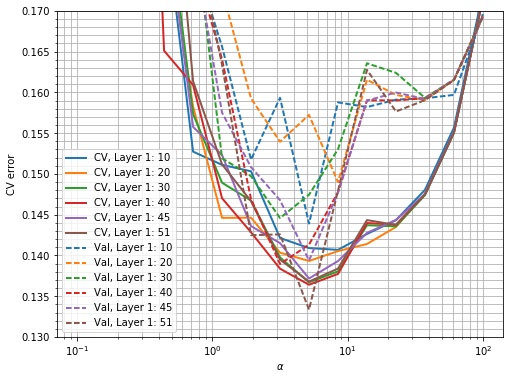

In [152]:
err_re = err_array.reshape((6, 15, 5))

fig, ax = plt.subplots(figsize=(8, 6))

nnodes = [10, 20, 30, 40, 45, 51]
for i in range(len(err_re)):
    ax.plot(err_re[i, :, 1], err_re[i, :, 2], lw=2, label='CV, Layer 1: '+str(nnodes[i]))

    
# Reset color cycle
ax.set_prop_cycle(None)
for i in range(len(err_re)):
    ax.plot(err_re[i, :, 1], err_re[i, :, 4], lw=2, ls='--', label=r'Val, Layer 1: '+str(nnodes[i]))
    
ax.set_ylim(0.13, 0.17)
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('CV error')
ax.minorticks_on()
ax.grid(which='both')
ax.legend()

# Choose best model and submit (currently SVR with RBF kernel)

In [153]:
# Data with X AND y.
df_train = pd.read_csv('train_clean.csv')

# Data with just X. You submit your prediction for y.
df_test = pd.read_csv('test_clean.csv')

print df_train.shape, df_test.shape
print df_labeled.columns

(1460, 53) (1459, 52)
Index([u'Id', u'SalePrice', u'OverallQual', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'TotalBsmtSF', u'1stFlrSF', u'FullBath',
       u'TotRmsAbvGrd', u'YearBuilt', u'MasVnrArea', u'Fireplaces',
       u'BsmtFinSF1', u'LotFrontage', u'ExterQual', u'BsmtQual',
       u'KitchenQual', u'BsmtFinType1', u'HeatingQC', u'GarageFinish',
       u'GarageType', u'Foundation_BrkTil', u'Foundation_CBlock',
       u'Foundation_PConc', u'Foundation_Slab', u'Foundation_Stone',
       u'Foundation_Wood', u'Neighborhood_Blmngtn', u'Neighborhood_Blueste',
       u'Neighborhood_BrDale', u'Neighborhood_BrkSide',
       u'Neighborhood_ClearCr', u'Neighborhood_CollgCr',
       u'Neighborhood_Crawfor', u'Neighborhood_Edwards',
       u'Neighborhood_Gilbert', u'Neighborhood_IDOTRR',
       u'Neighborhood_MeadowV', u'Neighborhood_Mitchel', u'Neighborhood_NAmes',
       u'Neighborhood_NPkVill', u'Neighborhood_NWAmes',
       u'Neighborhood_NoRidge', u'Neighborhood_NridgHt',
      

In [154]:
# Convert data to numpy arrays
# Predict ln(y) instead of y
y_train = np.log(df_train['SalePrice'].values)

X_train = df_train.drop(['Id', 'SalePrice'], axis=1).values
X_test = df_test.drop('Id', axis=1).values

# Create feature scaling object (mean/standard-deviation scaling).
# Only use the training set for determining the scaling. 
# Otherwise, you indirectly use information about the validation set.
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Perform feature scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Names of features
feat_columns = df_train.columns.drop(['Id', 'SalePrice'])

In [ ]:
# Optimal choice:
# array([1.66810054e+02, 3.59381366e-04, 1.35999846e-01, 1.16524839e-01, 1.36301778e-01])

In [157]:
C = 1.66810054e+02
gamma = 3.59381366e-04
reg = svm.SVR(C=C, kernel='rbf', gamma=gamma)
        
err_cv = cross_validation_error(reg, X_train, y_train, cv=10)

reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
err_train = error(np.exp(y_pred_train), np.exp(y_train))
        
err = [C, gamma, err_cv, err_train]
print err

[166.810054, 0.000359381366, 0.13472233893123939, 0.11576153298618164]


In [158]:
df_train_res = predict_sale_price(df_train, scaler, reg)
df_test_res = predict_sale_price(df_test, scaler, reg)

In [159]:
# Create submission file
df_submit = df_test_res[['Id', 'SalePricePred']]
df_submit = df_submit.rename(columns={'SalePricePred': 'SalePrice'})
df_submit.to_csv('submit.csv', index=False)
print df_submit.shape
df_submit.head(20)

(1459, 2)


,Id,SalePrice
0,1461,124699.957376
1,1462,156216.103670
2,1463,190580.458288
3,1464,199921.664880
4,1465,201253.413504
5,1466,179068.096575
6,1467,173739.706638
7,1468,168924.348697
8,1469,205725.981891
9,1470,133164.659451
